In [1]:
import torch
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

/home/avashchilko/abbyy9sem/course_cvdl/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/avashchilko/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [2]:
#!pip install -e .
#pip install  course_ocr_t3

from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import wandb
import pandas as pd

import torch

In [3]:
DATASET_PATH = Path('/') / 'DATA' / 'asaginbaev' / 'CourseOCRTask3' 

TRAIN_PATH, TEST_PATH = DATASET_PATH / 'Train', DATASET_PATH / 'Test'

assert DATASET_PATH.exists(), DATASET_PATH.absolute()
assert TRAIN_PATH.exists(), TRAIN_PATH.absolute()
assert TEST_PATH.exists(), TEST_PATH.absolute()

In [4]:
from torchvision.transforms import Resize, Compose, ToTensor
import torch.nn as nn
from task3pack.utils.data import SegmentationDataset

IMAGE_SIZE = [512, 512]
NAMES = ['path', 'code', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'barcode']

image_transforms = Compose([
    ToTensor(),
    Resize(IMAGE_SIZE),
])

target_transforms = Compose([
    Resize(IMAGE_SIZE),   
])

train_dataset = SegmentationDataset(csv_path=TRAIN_PATH / 'markup.csv', images_path=TRAIN_PATH / 'Images', csv_header=NAMES, csv_encoding='utf-16', 
                                   image_transforms=image_transforms, target_transforms=target_transforms, shape=IMAGE_SIZE)
test_dataset = SegmentationDataset(csv_path=None, images_path=TEST_PATH / 'Images', csv_header=NAMES, csv_encoding='utf-16', 
                                   image_transforms=image_transforms, target_transforms=target_transforms, shape=IMAGE_SIZE, is_test=True)

print(len(train_dataset), len(test_dataset))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)
print(test_dataset[0][0].shape, test_dataset[0][1])

val_ratio = 0.1
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

print(train_size, val_size)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
        [train_size, val_size])

8199 100
torch.Size([3, 512, 512]) torch.Size([1, 512, 512])
torch.Size([3, 512, 512]) 1105913212699e2e8a558191113acbd7.png
7380 819


In [5]:
from task3pack.utils.train import show_train_plots, train

In [6]:
from torch.nn import BCELoss

In [7]:
model_name = 'torch unet'

train_dataloader_config = {
    'batch_size': 8,
    'shuffle': True,
    'num_workers': 2,
}

test_dataloader_config = {
    'batch_size': 8,
    'shuffle': False,
    'num_workers': 2,
}

training_config = {
    'lr': 1e-3,
    'epochs': 20,
    'step_size': 25,
    'milestones': [23, 35, 75],
    'gamma': 0.7,
}


device = 'cuda:0'
criterion = BCELoss()

wandb.init(
    project='ocr task 3',
    name='{} {} epochs with lr={} faster data'.format(model_name, training_config['epochs'], training_config['lr']),
    config={
        'train_dataloader_config': train_dataloader_config,
        'test_dataloader_config': test_dataloader_config,
        'training_config': training_config,

    "architecture": model_name,
    "dataset": "MIDV-500",
    "criterion": "BCELoss",
    "optimizer": "Adam",
    "image_size": IMAGE_SIZE,  
    }
)
wandb.run.log_code('./task3pack/')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vashchilkoav. Use `wandb login --relogin` to force relogin


In [8]:
train_losses, test_losses, trained_model = train(
    train_dataset=train_dataset, 
    test_dataset=val_dataset, 
    model=model, 
    train_dataloader_kwargs=train_dataloader_config, 
    test_dataloader_kwargs=test_dataloader_config, 
    training_kwargs=training_config,
    criterion=criterion,
    device=device,
    wandb_instance=wandb,
)

Initial val loss: 0.3650643188001472
Epoch 1:
Train loss: 0.01362405568815586
Epoch 2:
Train loss: 0.007686068397772506
Epoch 3:
Train loss: 0.006871809891922283
Epoch 4:
Train loss: 0.006099588114788458
Epoch 5:
Train loss: 0.006296675025578841
Val loss: 0.005832457571530371
Epoch 6:
Train loss: 0.005979004921770193
Epoch 7:
Train loss: 0.005426935069919198
Epoch 8:
Train loss: 0.005278869552492368
Epoch 9:
Train loss: 0.005141113910238513
Epoch 10:
Train loss: 0.005344802960198181
Val loss: 0.005225134378933644
Epoch 11:
Train loss: 0.005040643212251708
Epoch 12:
Train loss: 0.004824766883157133
Epoch 13:
Train loss: 0.004752872554398569
Epoch 14:
Train loss: 0.00465672995042066
Epoch 15:
Train loss: 0.004606428533176662
Val loss: 0.005023695778679353
Epoch 16:
Train loss: 0.004462551923726148
Epoch 17:
Train loss: 0.004471435261824671
Epoch 18:
Train loss: 0.004261292010131809
Epoch 19:
Train loss: 0.0041786133129967425
Epoch 20:
Train loss: 0.004080662222422639
Val loss: 0.00487607

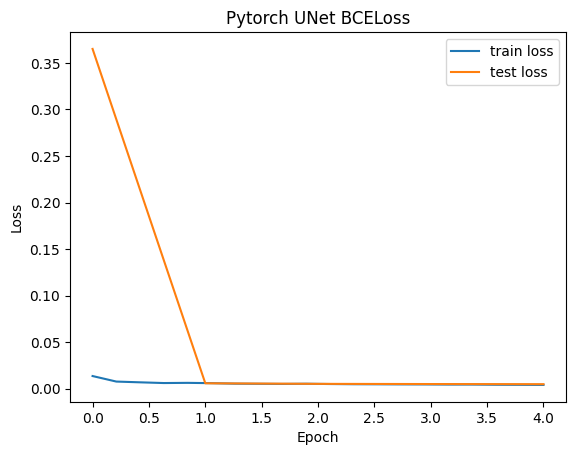

In [9]:
show_train_plots(train_losses, test_losses, 'Pytorch UNet BCELoss')

In [10]:
torch.save(model.state_dict(), f'./{model_name}.pth')
wandb.save(f'./{model_name}.pth')

['/home/avashchilko/abbyy10sem/course_ocr/task3/wandb/run-20230425_082849-9tcml6in/files/torch unet.pth']

In [11]:
import pickle 
from task3pack.utils.data import convert_segm_to_quadr

results_dict = {}

with torch.no_grad():
    for _, (x, name) in tqdm(enumerate(test_dataset)):
        result = trained_model(x[None, ...].to(device))[0]
        
        results_dict[name] = convert_segm_to_quadr(result.cpu(), image_size=IMAGE_SIZE).tolist()
        
with open('result_dict.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

wandb.save('./result_dict.pkl')

100it [00:28,  3.47it/s]


['/home/avashchilko/abbyy10sem/course_ocr/task3/wandb/run-20230425_082849-9tcml6in/files/result_dict.pkl']

In [12]:
wandb.finish()

lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.001


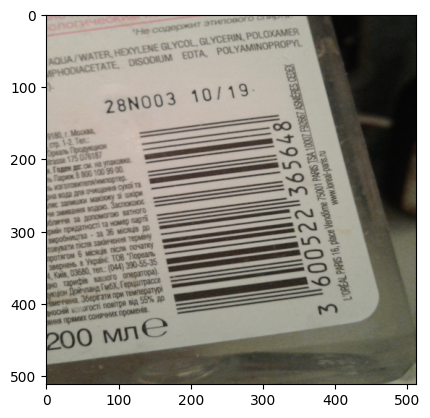

In [15]:
plt.imshow(test_dataset[0][0].permute(1, 2, 0))

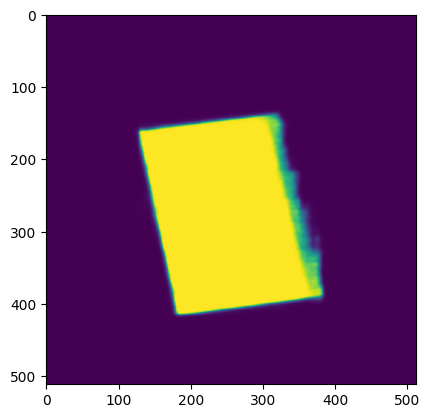

In [21]:
plt.imshow(trained_model(test_dataset[0][0][None, ...].to(device))[0].detach().cpu().permute(1, 2, 0).numpy())

In [38]:
from tqdm import tqdm
from PIL import Image

train_markup = pd.read_csv(TRAIN_PATH / 'markup.csv', encoding='utf-16', header=None, names=NAMES)
images_path = TRAIN_PATH / 'Images'

results_dict = {}

to_tensor = ToTensor()

with torch.no_grad():
    for idx in tqdm(range(len(train_markup))):
        image_path = images_path / train_markup.loc[idx, 'path']
        
        if image_path.exists():
            image = Image.open(image_path)
            tensor_image = image_transforms(image)
            result = model(tensor_image[None, ...].to(device))[0] 
            r = convert_segm_to_quadr(result.cpu(), image_size=IMAGE_SIZE).numpy()
            r[:, 0] *= image.size[0]
            r[:, 1] *= image.size[1]
            r = r.astype(int)
            
            results_dict[image_path] = {
                'x1': r[0, 0],
                'x2': r[1, 0],
                'x3': r[2, 0],
                'x4': r[3, 0],
                'y1': r[0, 1],
                'y2': r[1, 1],
                'y3': r[2, 1],
                'y4': r[3, 1],
            }


100%|█████████████████████████████████████████████████████████████████████████████| 8199/8199 [1:02:28<00:00,  2.19it/s]


In [40]:
with open('train_coord.pkl', 'wb') as fp:
    pickle.dump(results_dict, fp)

In [41]:
test_markup = pd.read_csv('markup.csv', encoding='utf-16', header=None, names=NAMES)
images_path = TEST_PATH / 'Images'

results_dict = {}

to_tensor = ToTensor()

with torch.no_grad():
    for idx in tqdm(range(len(test_markup))):
        image_path = images_path / test_markup.loc[idx, 'path']
        
        if image_path.exists():
            image = Image.open(image_path)
            tensor_image = image_transforms(image)
            result = model(tensor_image[None, ...].to(device))[0] 
            r = convert_segm_to_quadr(result.cpu(), image_size=IMAGE_SIZE).numpy()
            r[:, 0] *= image.size[0]
            r[:, 1] *= image.size[1]
            r = r.astype(int)
            
            results_dict[image_path] = {
                'x1': r[0, 0],
                'x2': r[1, 0],
                'x3': r[2, 0],
                'x4': r[3, 0],
                'y1': r[0, 1],
                'y2': r[1, 1],
                'y3': r[2, 1],
                'y4': r[3, 1],
            }

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.36it/s]


In [42]:
with open('test_coord.pkl', 'wb') as fp:
    pickle.dump(results_dict, fp)